### Importing all the relevant libraries and check the installed package versions

In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import pkg_resources
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import sobol_seq
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import time
import types

import matplotlib as mpl
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)  #> 3.0.0
print(sns.__version__)  #> 0.9.0

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for rq in requirements:
    print("{}=={}".format(*rq))

3.2.2
0.10.1
statsmodels==0.11.1
seaborn==0.10.1
scipy==1.5.0
pandas==1.0.5
numpy==1.18.5
matplotlib==3.2.2


## Import the EC payments database

In [ ]:
df = pd.read_excel('Database_Final_UPD_2020_corr.xlsx')

### Generate the series of quasi-random numbers for the analysis

In [ ]:
quasiRandom_df = pd.DataFrame(sobol_seq.i4_sobol_generate(4,2**17))

DistributionFiMax = 0.8+quasiRandom_df[0]*0.2
DistributionFiMin = 0.2+quasiRandom_df[1]*0.2

Residue_selector = quasiRandom_df[2].round(0).astype(int)

inputs = pd.concat([DistributionFiMax, DistributionFiMin, Residue_selector],axis=1)

### Rearrange the dataframe for our convenience

In [ ]:
dfb = df[['ProgrammingPeriod','Country','NUTS1Code','NUTS2Code','Year','CF_TOTAL','EAGGF','ERDF_TOTAL','ESF']].copy()
df2 = dfb.melt(id_vars=['ProgrammingPeriod','Country','NUTS1Code','NUTS2Code','Year'],var_name='FundingScheme')
df2b = df2[df2.Year<2018]
df3 = df2.pivot_table(index=['ProgrammingPeriod','FundingScheme','Country','NUTS1Code','NUTS2Code'],columns='Year', values='value')
df4 = df3.dropna(how='all').fillna(0)

### Get the slice corresponding to the set we'll be working on

In [ ]:
df4b = df4.loc[('2007-2013','ERDF_TOTAL')]

df4b.loc[pd.IndexSlice[:,:,'ITH1'],:]=df4b.loc[pd.IndexSlice[:,:,'ITH1'],:].values+\
df4b.loc[pd.IndexSlice[:,:,'ITH2'],:].values
df4b.loc[pd.IndexSlice[:,:,'ITH1'],:]
df4b=df4b.reset_index()
df4b.NUTS2Code[df4b.NUTS2Code=='ITH1']='ITH0'
df4b = df4b[df4b.NUTS2Code != 'ITH2']
df4b=df4b.set_index(['Country','NUTS1Code','NUTS2Code']).sort_index()

### Excluding years before the commencing of the programming periods

In [ ]:
dummy = []

diff = int(np.sort(np.array(list(set(df.ProgrammingPeriod))))[0][5:])+6-\
int(np.sort(np.array(list(set(df.ProgrammingPeriod))))[0][:4])

d_Var = pd.Series([k/diff for k in range(1,diff+1)],[y for y in \
range(int(np.sort(np.array(list(set(df.ProgrammingPeriod))))[0][:4]),
int(np.sort(np.array(list(set(df.ProgrammingPeriod))))[0][5:])+6)])

dummy.append(d_Var)

for pp in np.sort(np.array(list(set(df.ProgrammingPeriod))))[1:-1]:
    diff = int(pp[5:])+4-int(pp[:4])
    
    d_Var = pd.Series([k/diff for k in range(1,diff+1)],[y for y in range(int(pp[:4]),int(pp[5:])+4)])
    
    dummy.append(d_Var)
    
for pp in np.sort(np.array(list(set(df.ProgrammingPeriod))))[-1:]:
    diff = int(pp[5:])+5-int(pp[:4])
    
    d_Var = pd.Series([k/diff for k in range(1,diff+1)],[y for y in range(int(pp[:4]),int(pp[5:])+5)])
    
    dummy.append(d_Var)

### Normalise the cumulative figures

In [ ]:
df5 = df4b.copy()

Norm_df6 = ((df5.cumsum(axis=1).T/df5.cumsum(axis=1).max(axis=1).values).T).dropna(how='all')

### Define the outcome variables

In [ ]:
Norm_df6['$\phi$']=(Norm_df6.loc[:,[y for y in range(2007,2018)]]-dummy[-1]).cumsum(axis=1).iloc[:,-1]

Norm_df6['$\mu$']=(Norm_df6['$\phi$'].max()-Norm_df6['$\phi$'])/(Norm_df6['$\phi$'].max()-Norm_df6['$\phi$'].min())

### Set the trigger for the number of years the residual expenditure gets spread onto the last eligible year of the programming period

In [ ]:
ld1 = []
for iq,qr in enumerate(quasiRandom_df[3]):
    df8b = Norm_df6.copy()
    df8b[0]=(qr*(Norm_df6['$\mu$']*(len(dummy[-1])-1)).astype(int)).astype(int)+1
    for il in range(1,len(dummy[-1])):
        df8b[il]=df8b[0]-il
    df8b[df8b<1]=1
    cd = [il0 for il0 in range(len(dummy[-1]))]
    df8b['value']=iq
    cd.append('value')
    df8b = df8b[cd]
    ld1.append(df8b)
years = pd.concat(ld1)
years.set_index('value', append=True, inplace=True)

### Define the yearly residues

In [ ]:
def A(n):
    return [2**j/(2**n-1) for j in reversed(range(n))]

B9 = []
for k in reversed(range(2,12)):
    B9.append(pd.DataFrame([A(y) for y in range(1,k)],index=[y for y in range(1,k)],
                           columns=[y for y in range(1,k)]).fillna(0).sort_values(by=1,ascending=False))

### And the number of years from which the Excess get taken out

In [ ]:
def C(n):
    return [1/n for j in reversed(range(n))]

C9 = pd.DataFrame([C(y) for y in range(1,11)],index=[y for y in range(1,11)],
                           columns=[y for y in range(1,11)]).fillna(0).sort_values(by=1,ascending=False)

D = [C9,pd.DataFrame([A(y) for y in range(1,11)],index=[y for y in range(1,11)],
                           columns=[y for y in range(1,11)]).fillna(0).sort_values(by=1,ascending=False)]

## Get the EC payment slice for Italy

In [ ]:
Payments = df4b.loc['IT'].iloc[:,-12:].copy()
Payments.index=Payments.index.droplevel(0)

### Get the member-state figure our data will be compared against

In [ ]:
df1 = pd.read_excel('20181231 Pagamenti ammessi PO 2007-2013.xls',usecols=[0,1,2,3,4,5,7])
df_REGIO_capped = df1[(df1['CCI'].str.contains("161"))|df1['CCI'].str.contains("162")]
NUTS2_dic = {'ABRUZZO':'ITF1','BASILICATA':'ITF5','CALABRIA':'ITF6','CAMPANIA':'ITF3','EMILIA':'ITH5','FRIULI':'ITH4','LAZIO':'ITI4',
'LIGURIA':'ITC3','LOMBARDIA':'ITC4','MARCHE':'ITI3','MOLISE':'ITF2','PIEMONTE':'ITC1','PUGLIA':'ITF4','SARDEGNA':'ITG2','SICILIA':'ITG1',
'TOSCANA':'ITI1','TRENTINO':'ITH0','UMBRIA':'ITI2',"VALLE D'AOSTA":'ITC2','VENETO':'ITH3'}

df_REGIO_capped['NUTS2'] = df_REGIO_capped.REGIONE.map(NUTS2_dic)

df_REGIO_capped.DESCRIZIONE_PROGRAMMA = df_REGIO_capped.DESCRIZIONE_PROGRAMMA.str.replace(' Romagna', '')

### Attribute the orphan payments

In [ ]:
df_REGIO_capped.loc[df_REGIO_capped['NUTS2'].isnull(),'NUTS2'] = \
df_REGIO_capped['DESCRIZIONE_PROGRAMMA'].str.split(expand=True)[3].map(NUTS2_dic)

df_REGIO_nonAttributed = df_REGIO_capped[df_REGIO_capped.NUTS2.isna()]
df_REGIO_REGIO = df_REGIO_capped.dropna()

df_REGIO_REGIO=df_REGIO_REGIO.rename(columns={'ANNO':'Year'})

df_REGIO_REGIO_yearly=df_REGIO_REGIO.groupby(['Year','NUTS2']).sum()
df_REGIO_REGIO_yearly['Year']=df_REGIO_REGIO_yearly.index.get_level_values(0)
df_REGIO_REGIO_yearly=df_REGIO_REGIO_yearly
df_REGIO_REGIO_yearly.index= df_REGIO_REGIO_yearly.index.droplevel(0)

df_REGIO_pv = df_REGIO_REGIO_yearly.pivot_table(index='Year', columns='NUTS2', values='PAGAMENTO_AMMESSO_UE').fillna(0).T

### Re-distribute the residues as per the NUTS2 expenditures

In [ ]:
df_REGIO_multiplier_year=df_REGIO_nonAttributed.groupby('ANNO').sum().T.values*df_REGIO_pv/df_REGIO_pv.sum()

df_REGIO_multiplier_year['r']=1

df_REGIO_multiplier = df_REGIO_nonAttributed.groupby('ANNO').sum().T.values*\
pd.concat([df_REGIO_pv.sum(axis=1)/df_REGIO_pv.sum(axis=1).sum() for re in range(12)],axis=1)
df_REGIO_multiplier['r']=0
df_REGIO_multiplier.columns = df_REGIO_multiplier_year.columns

df_REGIO_residual = pd.concat([df_REGIO_multiplier,df_REGIO_multiplier_year])

### Evaluate the distance between the modelled expenditure and the MS incurred

In [ ]:
Expe = pd.concat([Payments.copy() for r in range(len(quasiRandom_df))])

Exp = Expe.copy()

Exp['r']=np.array([r for r in range(len(quasiRandom_df)) for er in range(len(Payments))])
N_df = pd.concat([Norm_df6.loc['IT','$\mu$'] for r in range(len(quasiRandom_df))])
N_df.index = N_df.index.droplevel(0) 

Est_expenditure = pd.concat([df_REGIO_pv.copy() for r in range(len(quasiRandom_df))])

y_slice = years.loc[pd.IndexSlice['IT',:,:]]
y_slice.index = y_slice.index.droplevel(0)

Exp.loc[:,2017]=Expe.loc[:,[y for y in range(2017,2019)]].sum(axis=1)
Exp.loc[:,[y for y in range(2018,2019)]]=0

Aggregate = Exp.loc[:,2017]*(1-(DistributionFiMax[Exp.r].values-N_df*(DistributionFiMax[Exp.r]-\
                                                                      DistributionFiMin[Exp.r]).values))

Exp.loc[:,2017] = Exp.loc[:,2017]*(DistributionFiMax[Exp.r].values-N_df*
                            (DistributionFiMax[Exp.r]-DistributionFiMin[Exp.r]).values)

residual = pd.concat(df_REGIO_residual[df_REGIO_residual.r==rs] for rs in Residue_selector)

for iy2,y2 in enumerate(reversed(range(2007,2017))):
    Exp[y2] = Expe[y2]*(DistributionFiMax[Exp.r].values-N_df*(DistributionFiMax[Exp.r]-DistributionFiMin[Exp.r]).values)
    
    for iy3,y3 in enumerate(reversed(range(y2,2016))):
        Exp[y2]+=Expe[y3+1]*(1-DistributionFiMax[Exp.r].values+N_df*(DistributionFiMax[Exp.r]-\
                DistributionFiMin[Exp.r]).values)*B9[iy3].loc[y_slice.iloc[:,iy3].values,(y3+1-y2)].values
        
    Exp[y2] += Aggregate*B9[0].loc[y_slice.iloc[:,0],iy2+1].values
    
Exp[2007] += Expe[2007]*(1-DistributionFiMax[Exp.r].values+N_df*(DistributionFiMax[Exp.r]-DistributionFiMin[Exp.r]).values)
Exp = Exp.drop('r',axis=1)

MS_Expenditure = (Est_expenditure+residual).drop('r',axis=1)

Distance = pd.DataFrame((np.abs(MS_Expenditure.cumsum(axis=1)-Exp.cumsum(axis=1)).sum(axis=1)/\
                         Expe.cumsum(axis=1).iloc[:,-1])).rename(columns={2016:'Distance'})

Distance['r']=np.array([r for r in range(len(quasiRandom_df)) for er in range(len(Payments))])

Distance_df = Distance.pivot_table(values=0,index='r',columns='NUTS2')

Distance_payments = pd.DataFrame((np.abs(MS_Expenditure.cumsum(axis=1)-Expe.cumsum(axis=1)).sum(axis=1)/\
                         Expe.cumsum(axis=1).iloc[:,-1])).rename(columns={2016:'Distance'})

Distance_payments['r']=Distance['r']

Distance_payments_df = Distance_payments.pivot_table(values=0,index='r',columns='NUTS2')

In [ ]:
Distance_df.columns = ['Pdm','AsV','Lgr','Lmb','Abr','Mls','Cmp','Apl','Bsl','Clb','Scl','Srd','TST','Vnt','FVG','EmR','Tsc',
                 'Umb','Mrc','Laz']
Distance_payments_df.columns = Distance_df.columns

In [11]:
Distance_df_sorted = Distance_df.T.reindex(Distance_df.max().sort_values(ascending=False).index).T
Distance_payments_df_sorted = Distance_payments_df.T.reindex(Distance_df.max().sort_values(ascending=False).index).T

### Uncertainty analysis - distribution plots

<Figure size 4800x3000 with 0 Axes>

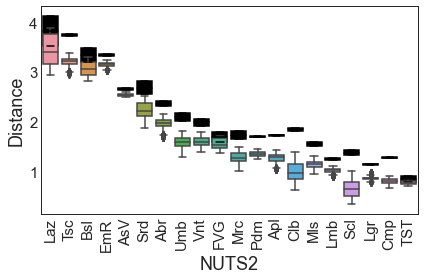

In [12]:
plt.figure(figsize=(16, 10), dpi= 300, facecolor='w', edgecolor='k')
fig, ax = plt.subplots()
sns.boxplot(x="variable", y="value", data=pd.melt(Distance_payments_df_sorted),color='k')
sns.boxplot(x="variable", y="value", data=pd.melt(Distance_df_sorted))
plt.ylabel('Distance',fontsize = 18)
plt.xlabel('NUTS2',fontsize = 18)
plt.xticks(rotation=90)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
ax.autoscale()
#plt.show()
plt.tight_layout()
plt.savefig('IT_boxplots_distance.png',dpi=300)

<Figure size 4800x3000 with 0 Axes>

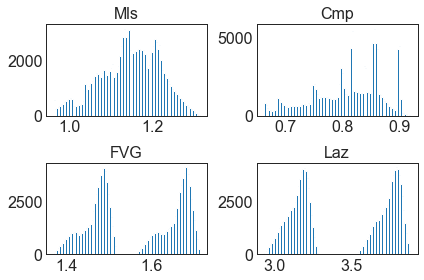

In [13]:
plt.figure(figsize=(16, 10), dpi= 300, facecolor='w', edgecolor='k')
plt.tight_layout()
c1 = ['Mls','Cmp', 'FVG','Laz']
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(Distance_df_sorted[c1[0]],bins = 100)
axs[0, 0].set_title(str(c1[0]))
axs[0, 0].set_xlabel('Distance')
axs[0, 0].set_ylabel('Occurrences')
axs[0, 1].hist(Distance_df_sorted[c1[1]],bins = 100)
axs[0, 1].set_title(str(c1[1]))
axs[0, 1].set_xlabel('Distance')
axs[0, 1].set_ylabel('Occurrences')
axs[1, 0].hist(Distance_df_sorted[c1[2]],bins = 100)
axs[1, 0].set_title(str(c1[2]))
axs[1, 0].set_xlabel('Distance')
axs[1, 0].set_ylabel('Occurrences')
axs[1, 1].hist(Distance_df_sorted[c1[3]],bins = 100)
axs[1, 1].set_title(str(c1[3]))
axs[1, 1].set_xlabel('Distance')
axs[1, 1].set_ylabel('Occurrences')

fig.tight_layout()
# plt.savefig('IT_multi_modal.png',dpi= 300)
plt.show()

<Figure size 4800x3000 with 0 Axes>

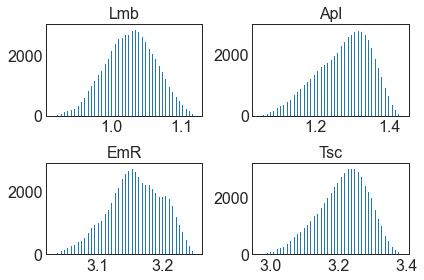

In [14]:
plt.figure(figsize=(16, 10), dpi= 300, facecolor='w', edgecolor='k')
plt.tight_layout()
c1 = ['Lmb','Apl', 'EmR','Tsc']
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(Distance_df_sorted[c1[0]],bins = 100)
axs[0, 0].set_title(str(c1[0]))
axs[0, 0].set_xlabel('Distance')
axs[0, 0].set_ylabel('Occurrences')
axs[0, 1].hist(Distance_df_sorted[c1[1]],bins = 100)
axs[0, 1].set_title(str(c1[1]))
axs[0, 1].set_xlabel('Distance')
axs[0, 1].set_ylabel('Occurrences')
axs[1, 0].hist(Distance_df_sorted[c1[2]],bins = 100)
axs[1, 0].set_title(str(c1[2]))
axs[1, 0].set_xlabel('Distance')
axs[1, 0].set_ylabel('Occurrences')
axs[1, 1].hist(Distance_df_sorted[c1[3]],bins = 100)
axs[1, 1].set_title(str(c1[3]))
axs[1, 1].set_xlabel('Distance')
axs[1, 1].set_ylabel('Occurrences')

fig.tight_layout()
# plt.savefig('IT_normal.png',dpi= 300)
plt.show()

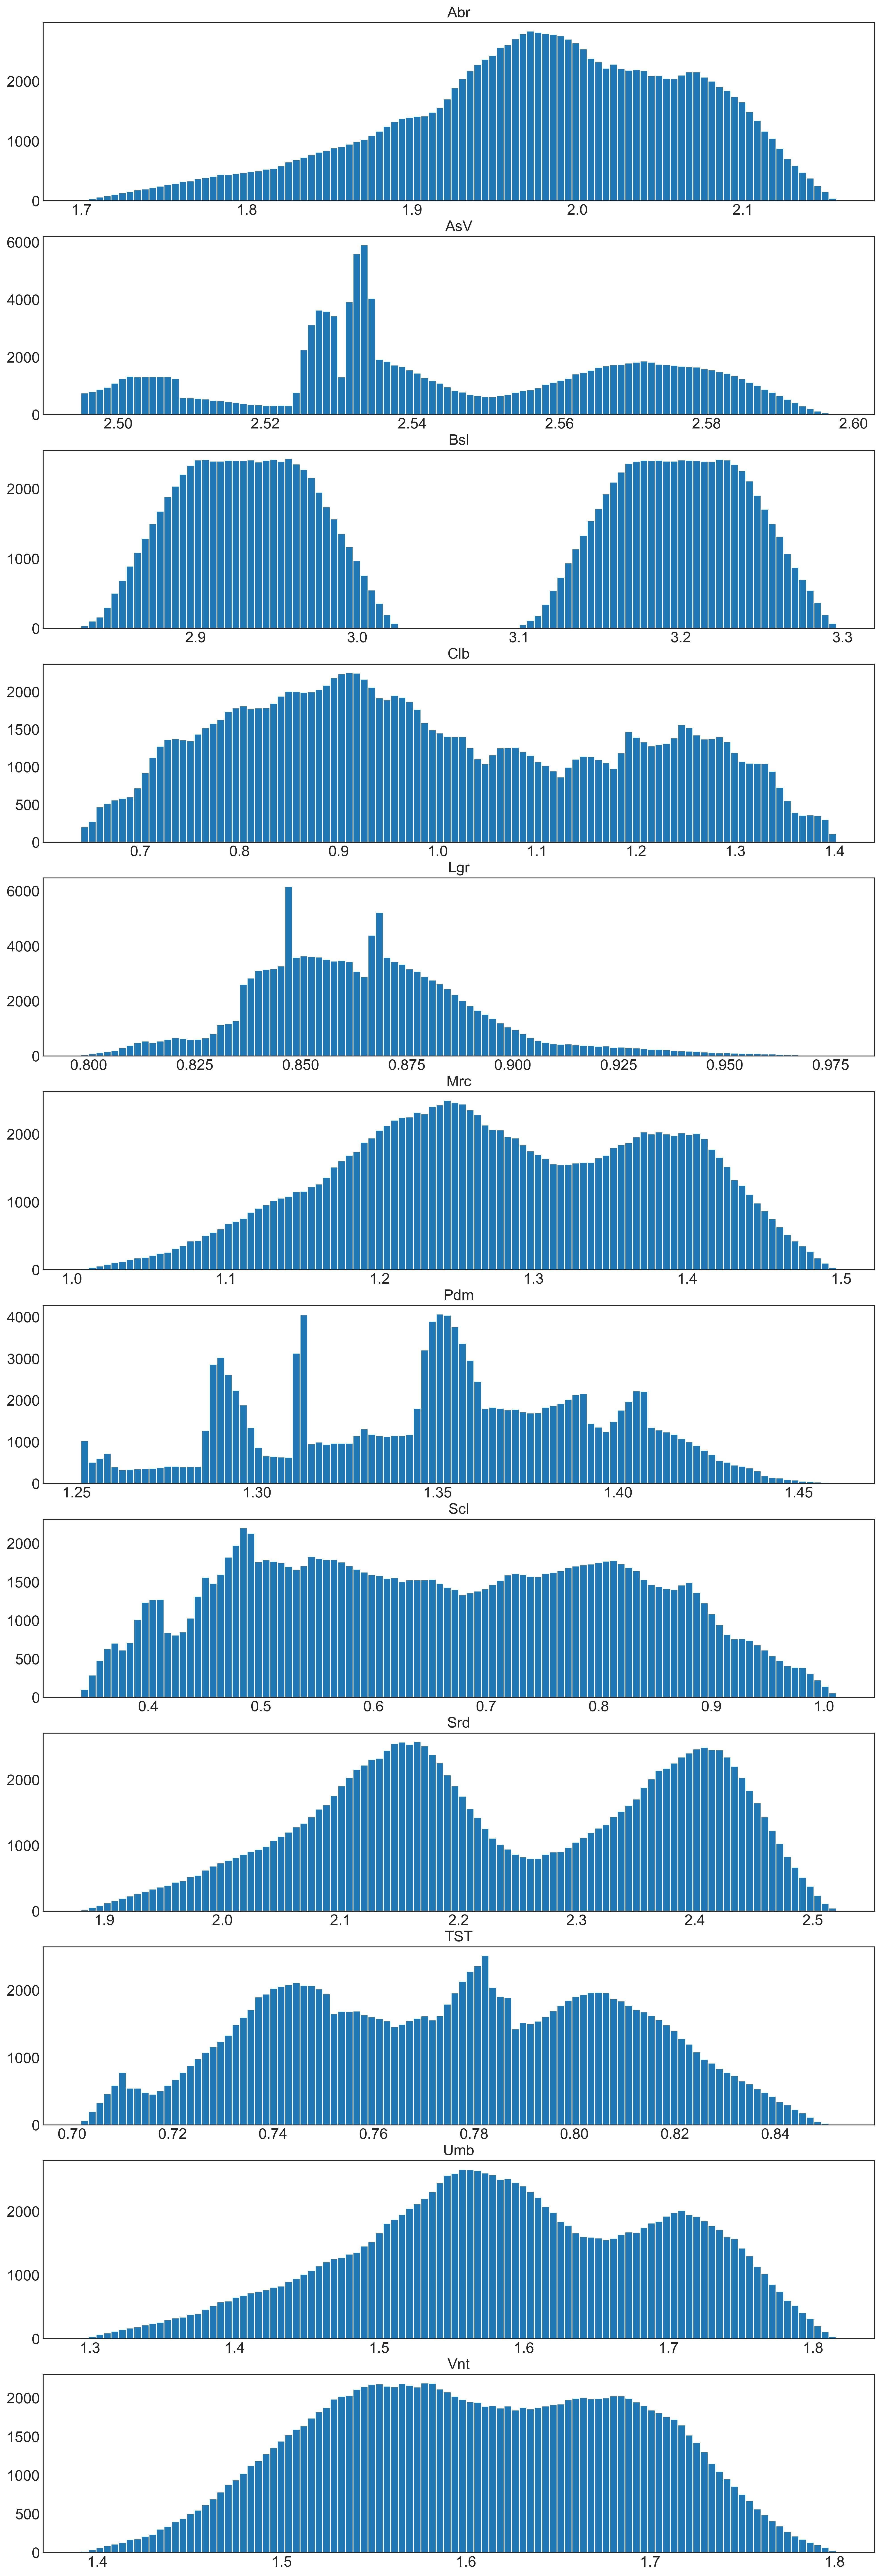

In [15]:
columns = list(set(Distance_df_sorted.columns) - set(['Lmb','Mls','Cmp','Apl','FVG','EmR','Tsc','Laz']))
columns.sort()

axs[0].hist(Distance_df_sorted[columns[0]],bins = 100)
axs[0].set_title(str(columns[0]))
axs[0].set_ylabel('Occurrences')
axs[1].hist(Distance_df_sorted[columns[1]],bins = 100)
axs[1].set_title(str(columns[1]))
axs[1].set_ylabel('Occurrences')
axs[2].hist(Distance_df_sorted[columns[2]],bins = 100)
axs[2].set_title(str(columns[2]))
axs[2].set_ylabel('Occurrences')
axs[3].hist(Distance_df_sorted[columns[3]],bins = 100)
axs[3].set_title(str(columns[3]))
axs[3].set_ylabel('Occurrences')
axs[4].hist(Distance_df_sorted[columns[4]],bins = 100)
axs[4].set_title(str(columns[4]))
axs[4].set_ylabel('Occurrences')
axs[5].hist(Distance_df_sorted[columns[5]],bins = 100)
axs[5].set_title(str(columns[5]))
axs[5].set_ylabel('Occurrences')
axs[6].hist(Distance_df_sorted[columns[6]],bins = 100)
axs[6].set_title(str(columns[6]))
axs[6].set_ylabel('Occurrences')
axs[7].hist(Distance_df_sorted[columns[7]],bins = 100)
axs[7].set_title(str(columns[7]))
axs[7].set_ylabel('Occurrences')
axs[8].hist(Distance_df_sorted[columns[8]],bins = 100)
axs[8].set_title(str(columns[8]))
axs[8].set_ylabel('Occurrences')
axs[9].hist(Distance_df_sorted[columns[9]],bins = 100)
axs[9].set_title(str(columns[9]))
axs[9].set_ylabel('Occurrences')
axs[10].hist(Distance_df_sorted[columns[10]],bins = 100)
axs[10].set_title(str(columns[10]))
axs[10].set_ylabel('Occurrences')
axs[11].hist(Distance_df_sorted[columns[11]],bins = 100)
axs[11].set_title(str(columns[11]))
axs[11].set_ylabel('Occurrences')
axs[11].set_xlabel('Distance')

# plt.savefig('IT_other_distributions.png',dpi= 300)
plt.show()

In [ ]:
Distance_df.to_excel('2020.06.15_distance_modelled_observed_expenditures.xlsx')